# Notebook 04a: Modeling - Keras Embeddings

## Contents:
1. [Summary](#section1)
2. [Building the Model](#section2)
3. [Model Fitting](#section3)
4. [Assessing the Model](#section4)
5. [Generating Lyrics](#section5)

# Summary<a name="section1"></a>
In this notebook I will build out a LSTM model in Keras that will take a sequence of tokenized words and predict an output. The input layer will be a Keras Embedding layer that will learn the relationships between words as the model trains, adding a layer of cohesion and an additional level of depth to the predictions. After building the model, I'll fit it on the dataset, review the training history, and finally predict on user-generated input strings.

Importing the necessary libraries.

In [33]:
import json, time, re, string, keras, pickle, h5py
import pandas as pd
import numpy as np
import tensorflow as tf

from numpy import random
from scipy import sparse
from scipy.sparse import coo_matrix

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, Flatten
from keras.utils.np_utils import to_categorical
from keras.callbacks import ModelCheckpoint
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
plt.style.use('fivethirtyeight')

%run ../assets/sql_cred.py

Since this is being run on an AWS EC2 GPU instance, I am verifying that the GPU is being recognized by the kernal.

In [15]:
print(tf.test.gpu_device_name())

config = tf.ConfigProto()
config.gpu_options.allow_growth = True

/device:GPU:0


In [16]:
def filename_format_log(file_path, 
                        logfile = '../assets/file_log.txt', 
                        now = round(time.time()), 
                        file_description = None): 
   
    try:
        ext = re.search('(?<!^)(?<!\.)\.(?!\.)', file_path).start() 
    except:
        raise NameError('Please enter a relative path with a file extension.') 
    
    stamp = re.search('(?<!^)(?<!\.)[0-z]+_[0-z]+(?=\.)', file_path).start()
    formatted_name = f'{file_path[:stamp]}{now}_{file_path[stamp:]}'  
    if not file_description:
        file_description = f'Saved at: {time.asctime(time.gmtime(now))}'
    with open(logfile, 'a+') as f:
        f.write(f'{formatted_name}: {file_description}\n')
    return formatted_name, now, file_description

In [17]:
X_reshape = np.load('../assets/1549597149_LSTM315_300Xreshape.npy')

In [18]:
y_cat_coo = sparse.load_npz('../assets/1549597149_LSTM315_300ycat.npz')

In [19]:
y_cat = y_cat_coo.toarray()

In [21]:
with open('../assets/1549597149_LSTM315_300tokenizer.pkl', 'rb') as f:
    tokenizer = pickle.load(f)

Saving vocab_size to the local namespace so it can be referenced as the output shape for the final layer of my model.

In [22]:
vocab_size = len(tokenizer.word_index) + 1

In [23]:
vocab_size

12335

## Building the Model<a name="section2"></a>

LSTM models have shown great performance for NLP processes such as text generation. They build on the framework of recurrent neural networks (RNN) by adding an additional cell state that allows the model to tune how data persists over time. This helps address one of the shortcomings of more simple RNNs - the vanishing gradient problem where data occurring earlier in the dataset becomes less likely to be considered when making predictions. This persistence is balanced by a 'forget gate' which allows data to be selectively dropped from memory. As the model trains on the input data these parameters are tuned to optimize predictions based on a given loss function. 

Because I want the model to understand the relationship between words, not just from a context but also from content, I am setting the input layer as an Embedding layer. This will be initialized with random weights that will be optimized as the model fits. This hope is that adding this additional layer of meaning will support better predictictions with user generated seed inputs. Since the vocabulary is relatively large, I'm starting with a relatively modest densification of the data with a 3000 feature embedding space before moving to a tighter 300 feature space (as seen below).

The embedding layer will then be passed to the first LSTM layer. This layer will consist of 300 nodes and allow sequences to be passed to the next LSTM layer of 150 nodes. This aspectct is important as it relates to the core functional difference between LSTM and traditional RNN layers. Without the ability to pass sequences downstream the first layer would effectctively function like a leaky RNN. 

The second LSTM layer will pass the data to a dense layer with 100 nodes and a relu activation function. The idea here is that the model is wide enough in the early layers to pick out important features without overtraining and just returning an existing lyric or loop. By starting with 3000 features and narrowing as data moves downstream, there will be a funnel effect resulting in more generalizable predictions that account for a broader understanding of relationship in the data.

Finally, the output layer will be a softmax activated dense layer with the same shape as the input vocabulary. This will allow for predictions tied back to the initial corpus. The model will be optimized with ADAM, an adaptive gradient descent function with randomized initialization points which allows it to be faster and generally more effective than other optimization algorithms. Finally, the model will be assessed on accuracy based on the ground truth of actual next words in the track.

In [24]:
seq_len=4

# Compile model
model = Sequential()
model.add(Embedding(vocab_size, 300, input_length=seq_len, mask_zero=True))
model.add(LSTM(300, return_sequences=True))
model.add(LSTM(150))
model.add(Dense(100, activation='relu'))
model.add(Dense(y_cat.shape[1], activation='softmax'))

model.compile(
    loss = 'categorical_crossentropy',
    optimizer = 'adam',
    metrics = ['accuracy'])

The model will be run on GPU with a relatively large batch size of 10000 sequences over 150 epochs. This is somewhat modest considering the model is being fit without the foundation of pre-trained word vectors. Considering the size of the dataset, nearly 600000 sequences, this will allow for a reasonable starting point to assess model architecture before moving toward potentially more complex or time consuming systems.

## Model Fitting<a name="section3"></a>
The model will be run in batches scaled to minimize overfitting while also allowing the model to effectively learn the data. Since the data is shuffled with each epoch, this helps mitigate the need for explicit validatation such as a train/test split. The number of epochs will be adjusted until we either see the accuracy curve begin to fall or the loss function being to grow. 

In [25]:
# Train model on dataset
with tf.device('/gpu:0'):
    history = model.fit(X_reshape,
              y_cat,
              verbose=1,
              batch_size=5000,
              epochs=300, 
             )
    
formatted_name, now, file_description= filename_format_log('../models/LSTM315_300model.h5')
model.save(formatted_name)

Epoch 1/300
567142/567142 [==============================] - 63s 112us/step - loss: 6.4909 - acc: 0.1223
Epoch 2/300
567142/567142 [==============================] - 61s 107us/step - loss: 5.7797 - acc: 0.1245
Epoch 3/300
567142/567142 [==============================] - 61s 107us/step - loss: 5.7649 - acc: 0.1245
Epoch 4/300
567142/567142 [==============================] - 61s 108us/step - loss: 5.7135 - acc: 0.1245
Epoch 5/300
567142/567142 [==============================] - 61s 107us/step - loss: 5.5009 - acc: 0.1253
Epoch 6/300
567142/567142 [==============================] - 61s 107us/step - loss: 5.3271 - acc: 0.1423
Epoch 7/300
567142/567142 [==============================] - 61s 107us/step - loss: 5.1002 - acc: 0.1674
Epoch 8/300
567142/567142 [==============================] - 61s 108us/step - loss: 4.9180 - acc: 0.1847
Epoch 9/300
567142/567142 [==============================] - 61s 108us/step - loss: 4.7972 - acc: 0.1935
Epoch 10/300
567142/567142 [===========================

The training output shows that the model was fit on 576641 samples to an accuracy of 81.05%. 

In [ ]:
# model = keras.models.load_model('../models/1549265762_LSTM_Model.h5')

## Assessing the Model<a name="section4"></a>

Reviewing the model summary and looking to understand how well the model was fit to the data.

In [27]:
# Print model summary
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 4, 300)            3700500   
_________________________________________________________________
lstm_1 (LSTM)                (None, 4, 300)            721200    
_________________________________________________________________
lstm_2 (LSTM)                (None, 150)               270600    
_________________________________________________________________
dense_1 (Dense)              (None, 100)               15100     
_________________________________________________________________
dense_2 (Dense)              (None, 12335)             1245835   
Total params: 5,953,235
Trainable params: 5,953,235
Non-trainable params: 0
_________________________________________________________________
None


The model summary shows that the model trained on just under 6M parameters. Due to the shape of the input layer, nearly 4000000 of these were in the vectorized word embeddings.

Plotting training loss alongside training accuracy. 

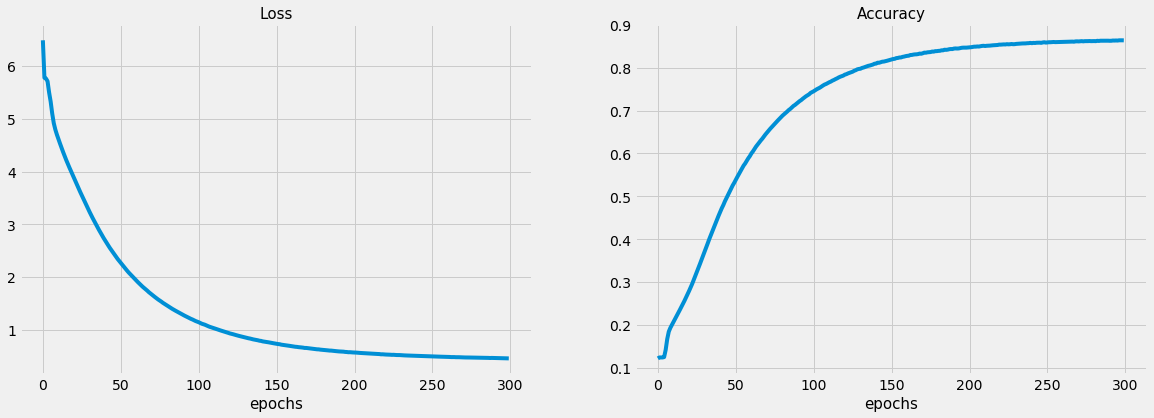

In [28]:
fig, ax = plt.subplots(ncols=2, nrows=1, figsize=(18,6))

ax[0].plot(history.history['loss'])
ax[0].set_title("Loss", fontsize=15);
ax[0].set_xlabel("epochs",fontsize=15);

ax[1].plot(history.history['acc'])
ax[1].set_title("Accuracy",fontsize=15);
ax[1].set_xlabel("epochs",fontsize=15);

The loss vs accuracy plots show that we have not started overtraining our model yet as we are still gaining accuracy. While it would be nice to validate fitting against a train / test split, the size of the dataset would not allow that operation on the current EC2 GPU instance. Additionally, from my research into this type of language processing / language generation task it seems that training the model without internal validation scoring is the norm. This is perhaps due to the fact that there is no such thing as a ground truth for predictive accuracy when it comes to the task of generating de novo text. It would in fact be detrimental if the seed text immediatedly predicted into existing lyrics as this would not accomplish the desired function of this model.

## Generating Lyrics<a name="section5"></a>

Defining a helper function to add variability into the next word predictions. The idea behind this code, inspired by the Keras LSTM example available on the Keras github repo, is that we can tune the tolerance of our model for predictive accuracy. The helper function will scale predictions and then randomly sample from a distribution of likely outcomes to tune predictive repetition and prevent song lyric looping.

In [29]:
def sample(preds, temperature=1.0):
    preds = np.asarray(preds).astype('float64')
    preds = np.log(preds) / temperature
    exp_preds = np.exp(preds)
    preds = exp_preds / np.sum(exp_preds)
    probas = np.random.multinomial(1, preds, 1)
    return np.argmax(probas)

Defining a function for generating lyrics. The core functionality of this function is to take a user generated seed, clean and tokenize the text, convert it to a word vector, and then generate a prediction using our 4 in 1 out window. As these predictions are made, they are appended to a doc of specified length as well as the next seed group. This process repeats until the desired song length is produced.

In [46]:
def generate_lyrics(seed, 
                    seq_len = 4, 
                    song_len = 50,
                    temperature = 1.0,
                    model_dir = None):
    
    if model_dir:
        model = keras.models.load_model(f'{model_dir}/*.h5')
        
        with open(f'{model_dir}/*.pkl', 'rb') as f:
            tokenizer = pickle.load(f)
    else:
        model = model

        tokenizer = tokenizer
    
    seed_clean = seed.lower().split(' ')
    doc = []

    while len(doc) < song_len:
        text = [seed_clean]
        sequence = [tokenizer.texts_to_sequences([word])[0] for word in text]
        pad_sequence = pad_sequences(sequence, maxlen=seq_len, truncating='pre')
        sequence_reshape = np.reshape(pad_sequence, (1, seq_len))

        yhat = model.predict(sequence_reshape, verbose=0)[0]
        next_index = sample(yhat, temperature)
        
        for word, index in tokenizer.word_index.items():
            if index == next_index:
                seed_clean.append(word)
                doc.append(word)

    return ' '.join(doc)

Helper function borrowed from the EDA notebook to help visualize the structure of tracks produced by this model.

In [31]:
def lyric_grid(track):
#     track = df.loc[track_id, 'clean_lyrics']
    
    lyrics_spaced = re.sub(r'( +)', ' ', track)
    lyrics_spaced = re.sub(r'\n ', '', lyrics_spaced)
    lyrics_split = lyrics_spaced.split(' ')
    
    N = len(lyrics_split)
    grid = np.zeros(shape=(N,N), dtype='int')
    
    for i in range(N):
        hits = [j for j, word in enumerate(lyrics_split) if word == lyrics_split[i]]
        grid[i,[hits]] = 1 
    
    plt.figure(figsize=(16,12))
    plt.title('Repetition in Track');
    plt.xlabel('Word Number');
    plt.ylabel('Word Number');
    sns.heatmap(grid, cmap='Greys', cbar=False, xticklabels=[], yticklabels=[]);
    
    plt.show();
    
    rep_ratio = np.around(((N - len(set(lyrics_split))) / N), 2)
    
    print('\n')
    print(f'The repetition ratio for this track is {rep_ratio}')
    print('\n')
    print(track)
    return 

Generating lyrics. Since the average song length in the dataset is between 240-280 words I will set the desired output length to 250.

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in log
  This is separate from the ipykernel package so we can avoid doing imports until


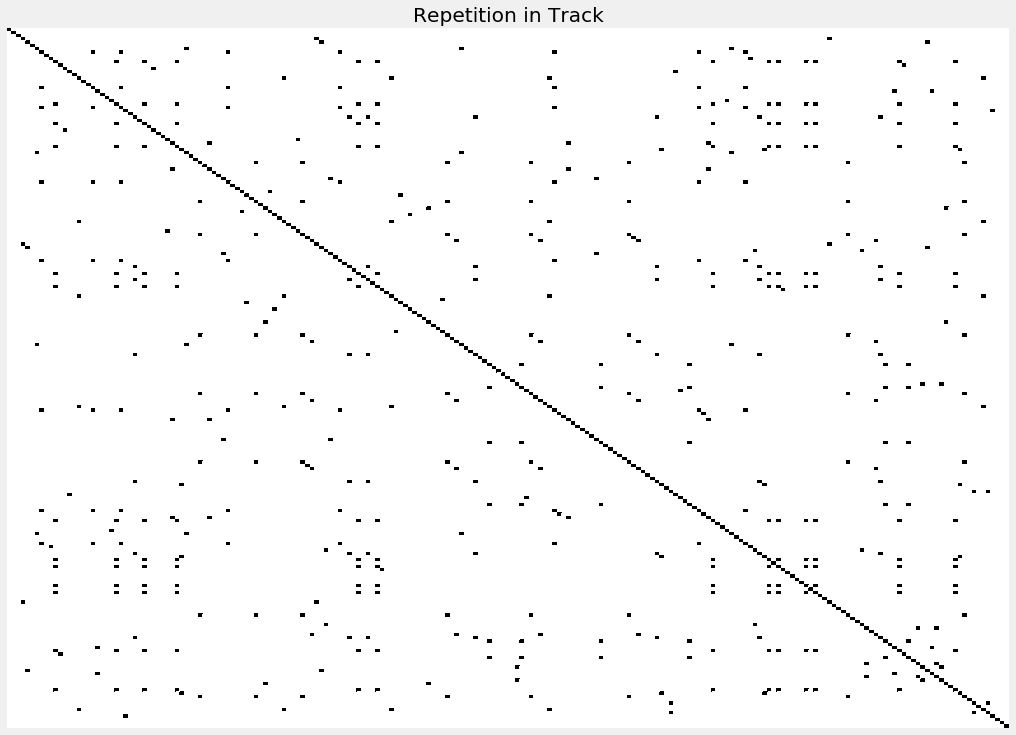



The repetition ratio for this track is 0.4



 best now its my life at me 
 i dont want you back 
 when were grey and old 
 cause i have hella feelings for you 
 i wont try to keep you free 
 when she act down that you see me 
 silly party the bout that says stress 
 so i sit with youre it 
 take the last time 
 youre never alright 
 and nothing went down 
 the rest of my life is so hard 
 i tried to tell you who to 
 love you feel bad 
 and but it feels 
 never ever 
 much each time in us 
 but the heaven of me 
 ooh girl to death 
 maybe im waking up today 
 ill be good im on the pursuit of happiness and 
 i know everything that was own 
 hearing even just so im dumb away 
 one nights took the rest of need no way to see if we were on ahead 
 im sorry 
 i know that you still care for me 
 rosanna 
 all i want is to see you smile 
 you feel like summertime oh yes you do 
 you call out my name baby 
 hear the sound this is a secret of to im gonna have you back im doing a good life 
 h

In [34]:
lyrics = generate_lyrics('eyes are for lovers',
                         seq_len=4,
                         song_len=250,
                         model_dir=None
                        )
lyric_grid(lyrics)

Overall these are fairly readable lyrics, though the word flow is not as consistent as the 3000 feature embedding space. The song structure also appears to be more choppy, however this may be an indication that as the model builds a stronger sense of how words interconnect the model requires more depth to effectively reproduce meaningful parings. Regardless, these are largely interpretable lyrics that I would not immediately identify as artificial.  

Repeating on the same seed to gauge consistency of the output

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in log
  This is separate from the ipykernel package so we can avoid doing imports until


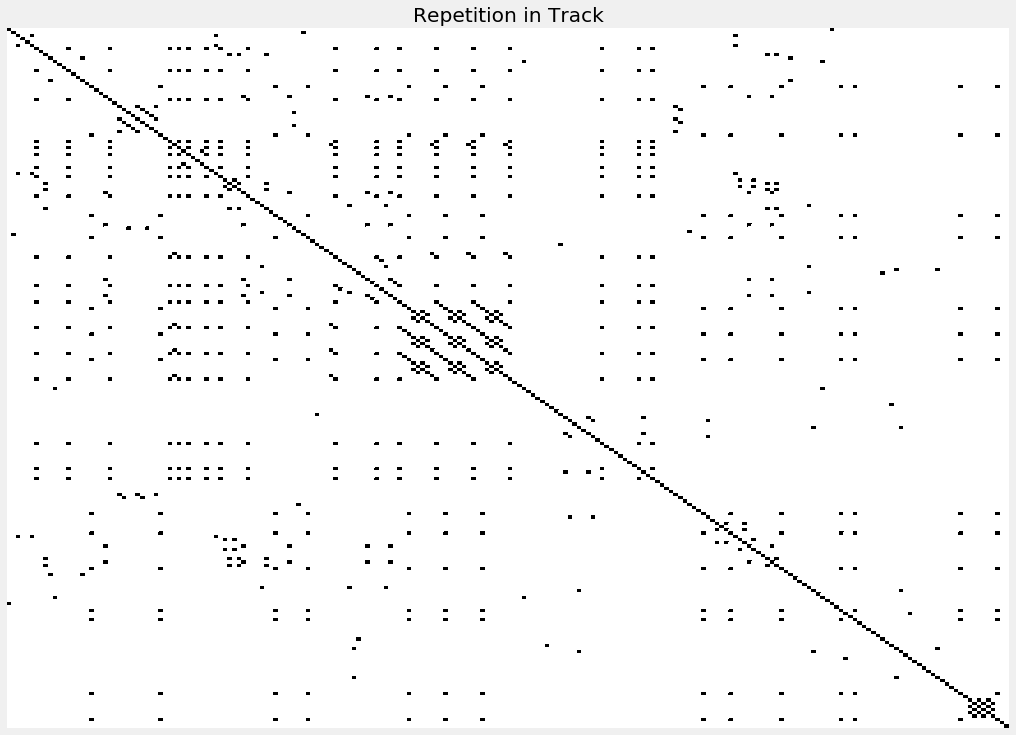



The repetition ratio for this track is 0.47


so good 
 dont go run dont you take me to the left past you were dead to mine 
 i can still love you tonight 
 this much is true 
 this much is true 
 this i promise you 
 for you who you are not who you why dont you let me let me love you baby 
 trust in me when i say 
 oh love is very good 
 i keep up going down for you 
 im fallin in and out 
 of love with you 
 im in love with you 
 am i wild enough 
 wild enough for you 
 am i wild enough 
 wild enough for you 
 am i wild enough 
 wild enough for you 
 cause its the only thing that makes us feel figured up 
 ill never break your heart 
 ill never make you cry 
 id rather die than live without you 
 ill give you everything hey girl 
 if this much aint very lame uh i never done no more 
 no i dont let no love let time 
 hold me love me i want to see life 
 driving in your car 
 the speed so fast i felt like i was drunk 
 city lights lay out before us 
 and your arms felt nice wrapped a

In [35]:
lyrics = generate_lyrics('eyes are for lovers',
                         seq_len=4,
                         song_len=250,
                         model_dir=None
                        )
lyric_grid(lyrics)

This time the model began looping, indicating the predictions may benefit from a slightly looser tolerance when predicting the next word.

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in log
  This is separate from the ipykernel package so we can avoid doing imports until


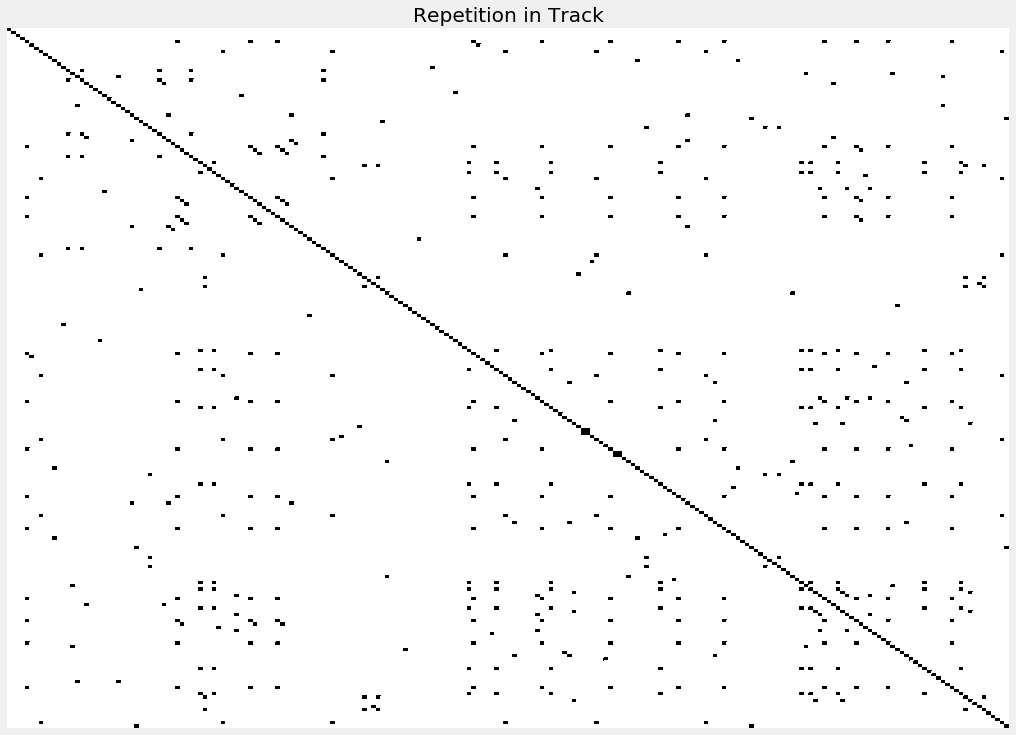



The repetition ratio for this track is 0.4



 better than ya 
 understand i cant pay the empty lips 
 it years not to say 
 just to make this dock my home 
 now im just gonna meet your way again 
 find a place to make your body 
 i dont want to let you go til you see the light 
 take me home tonight 
 i dont want another pretty face 
 i dont want your body 
 walks away one last 
 made to know the dark thats why we fuck baby 
 go hard and go again 
 but in winters chill or summers breeze 
 one thing will not be lovers out with my wings without you 
 i cant help myself no 
 you mean the world of her they never loved me 
 i thought you had some kind of love baby drip drip 
 thats the newest things i ever ever done 
 but keep it all a hundred did you have faith 
 when i was your ring nauseous wall 
 the bag of em 
 i wouldnt have it any other way 
 heaven knows a sinner needs a saint 
 oh but when you say you love me 
 i couldnt make you love me 
 cause i dont see me no matter what i sa

In [36]:
lyrics = generate_lyrics('eyes are for lovers',
                         seq_len=4,
                         song_len=250,
                         model_dir=None
                        )
lyric_grid(lyrics)

This is the best output so far, with an interesting variation in line length and overall consistent theme, even though some of the word combinations are VERY metaphorical.

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in log
  This is separate from the ipykernel package so we can avoid doing imports until


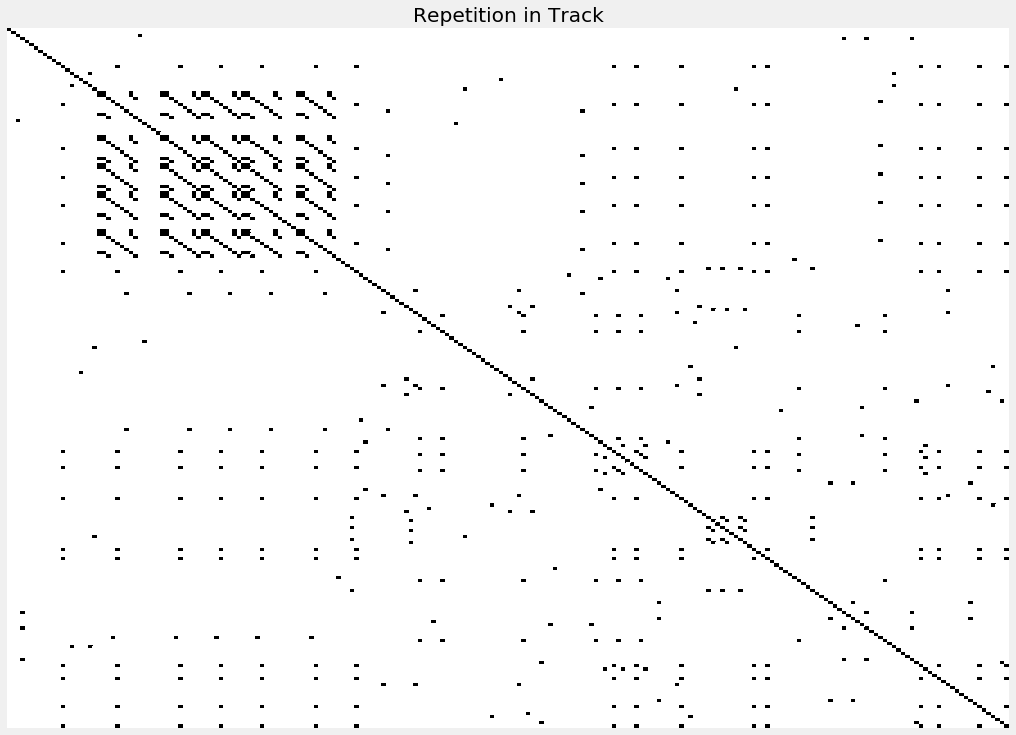



The repetition ratio for this track is 0.47



 ignore right now and comes back like some other kisses fun 
 well you say it til she appear it yeah 
 big big booty what you got a big booty 
 now baby uh youre gorgeous 
 big big booty what you got a big booty 
 big big booty what you got a big booty 
 big big booty what you got a big booty go to work 
 big big booty what you got a big booty 
 but most of all you are just absolutely bootyful aint that a freak huh 
 from the night that i fell in love girl 
 i miss us baby oh yeah 
 woo ooh stand lets watch me cry 
 she is the nights that i call the fiveo 
 if they show up then we are gonna give a good show 
 i just wanna see you 
 i wanna laugh with you 
 i wanna scream keep your heart 
 just pretend that you turn me in the street 
 all night long all night ah yeah all night once you get started you cant sit up without years 
 but i must spend all my time 
 cover your crystal eyes 
 and let your love show 
 and youll know what i mean 
 

In [37]:
lyrics = generate_lyrics('eyes are for lovers',
                         seq_len=4,
                         song_len=250,
                         model_dir=None
                        )
lyric_grid(lyrics)

The next hip-hop chart topper?

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in log
  This is separate from the ipykernel package so we can avoid doing imports until


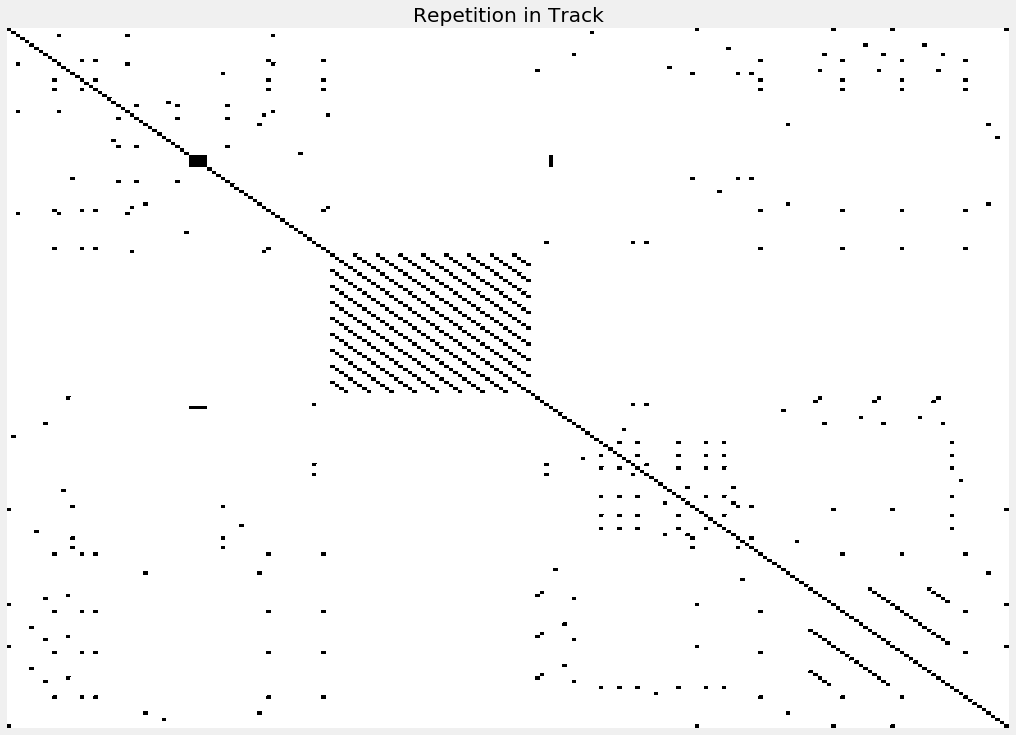



The repetition ratio for this track is 0.52


so good 
 dont act gonna go all 
 but your bitches 
 you dont have to be what you want when you get older 
 call out the flames 
 dont know the sun i say has probably never out of the door no 
 oh oh oh oh 
 walk heavy will be the matter thing them on goodnight ooh 
 i know you dont belong 
 now im asking questions 
 no one pushes me around you know everybody feels this way sometimes 
 everybody feels this way sometimes 
 everybody feels this way sometimes 
 everybody feels this way sometimes 
 everybody feels this way sometimes 
 everybody feels this way sometimes 
 everybody feels this way sometimes 
 everybody feels this way sometimes 
 everybody feels this way wild to love me oh baby how it breaks your heart 
 youd make good money and come home early 
 and youd kiss me and hold me each night 
 we would have children and they would be so beautiful 
 and wed raise them and all would be right 
 ill be with you from dusk till dawn 
 baby 

In [38]:
lyrics = generate_lyrics('eyes are for lovers',
                         seq_len=4,
                         song_len=250,
                         model_dir=None,
                         temperature=0.8
                        )
lyric_grid(lyrics)

Decreasing the temperature / predictive tolerance increases repetition, as expected.

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in log
  This is separate from the ipykernel package so we can avoid doing imports until


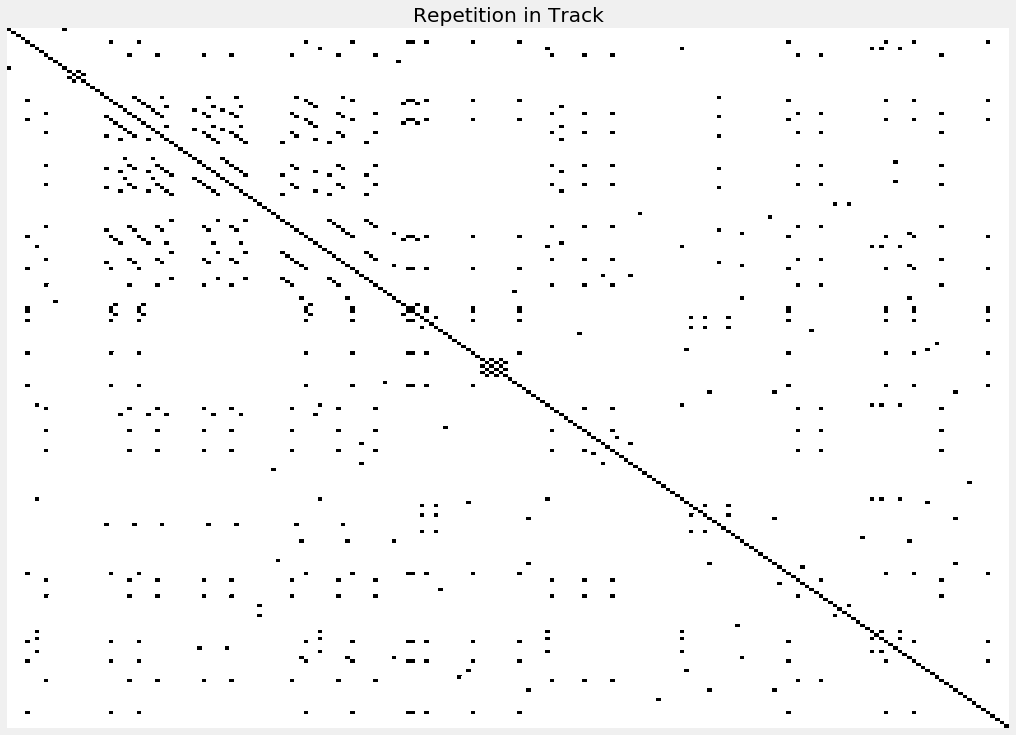



The repetition ratio for this track is 0.44


so damn crazy hey 
 you deserve to hear the world i am 
 so hold tight 
 hold tight 
 oh she said 
 any way you want it 
 thats the way you want it 
 thats the way it is 
 some thingsll never change 
 thats just the way it is 
 thats just the way it is 
 lately ive been puttin in my time 
 is this the way that you want it to end 
 is this the way that you leave me 
 is this the kind of do that 
 i want you 
 you want her you need her 
 but im not giving up 
 ima love you boy topdown bottomup 
 topdown bottomup topdown bottomup 
 thinking of you 
 like a river flows surely to the sea 
 it was divine door 
 im the only one for me 
 youre the one who keeps me on my own 
 because he dont mind 
 something everybody happened to love her 
 however leaving her a long way from her home 
 and that aint no promise cracking over time 
 a game truth 
 you wear the game charm 
 but happiness the lights have been laughing 
 its been alone come and lonel

In [40]:
lyrics = generate_lyrics('eyes are for lovers',
                         seq_len=4,
                         song_len=250,
                         model_dir=None,
                         temperature=1.2
                        )
lyric_grid(lyrics)

Interestingly, this still has a similar repetition ratio, though it is more intermittant and mostly limited to duplicate lines

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in log
  This is separate from the ipykernel package so we can avoid doing imports until


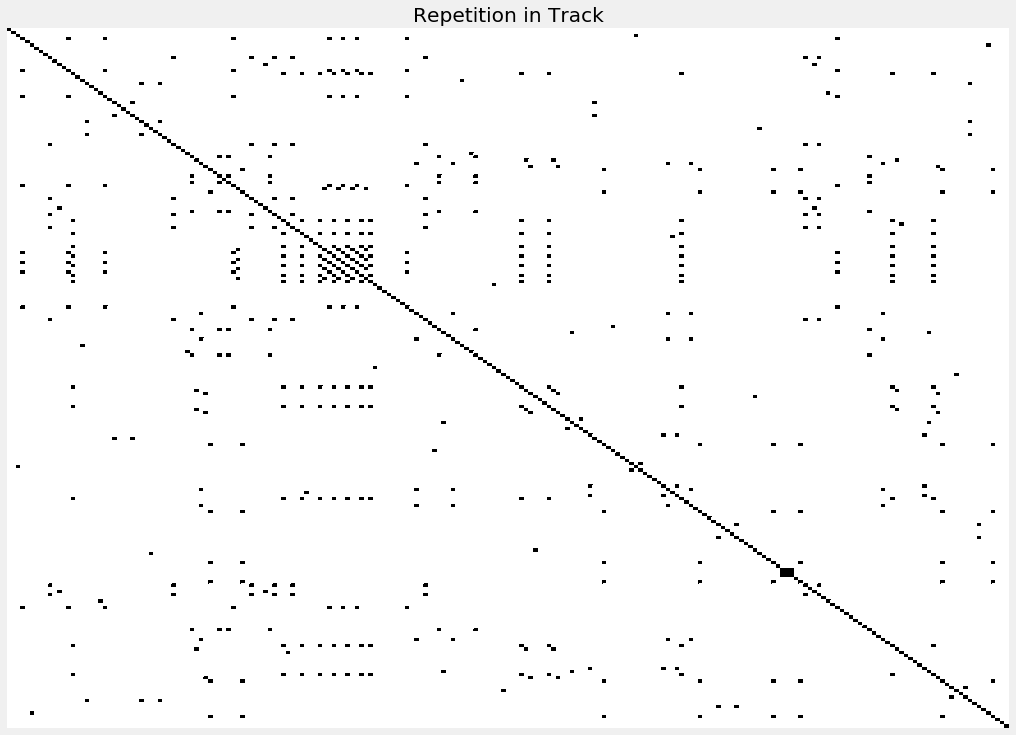



The repetition ratio for this track is 0.39



 ignore right now and comes back like youve got the joy of turns 
 and i would do a million things people and forget 
 im reminded our fool im not a little bit deep a 
 but let the words burn with me 
 dont you want to see me mistreat me 
 and try to store the pain inside of me 
 the minute i know the time i need anything 
 more i try and i try and i try and i try 
 i was taking pictures 
 out there havin kill 
 and if you were the answer for me 
 that night you went 
 do stop with me alone 
 when she was left this day from dying 
 i dont want another pretty face 
 i dont want nobodys body that your body babe 
 all im trying to wait for diamond no 
 or sweet now sweet simple mind cause 
 its all you need 
 all i ask you 
 is to walk away real 
 so sad are fast 
 so we cant go another bit video child to almost 
 oh oh oh listen to the music of the moment people long and nigga 
 big moons going drunk 
 remind me after bad you lie 
 i dont 

In [41]:
lyrics = generate_lyrics('eyes are for lovers',
                         seq_len=4,
                         song_len=250,
                         model_dir=None,
                         temperature=1.2
                        )
lyric_grid(lyrics)

This is more in line with what we would expect for human produced lyrics

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in log
  This is separate from the ipykernel package so we can avoid doing imports until


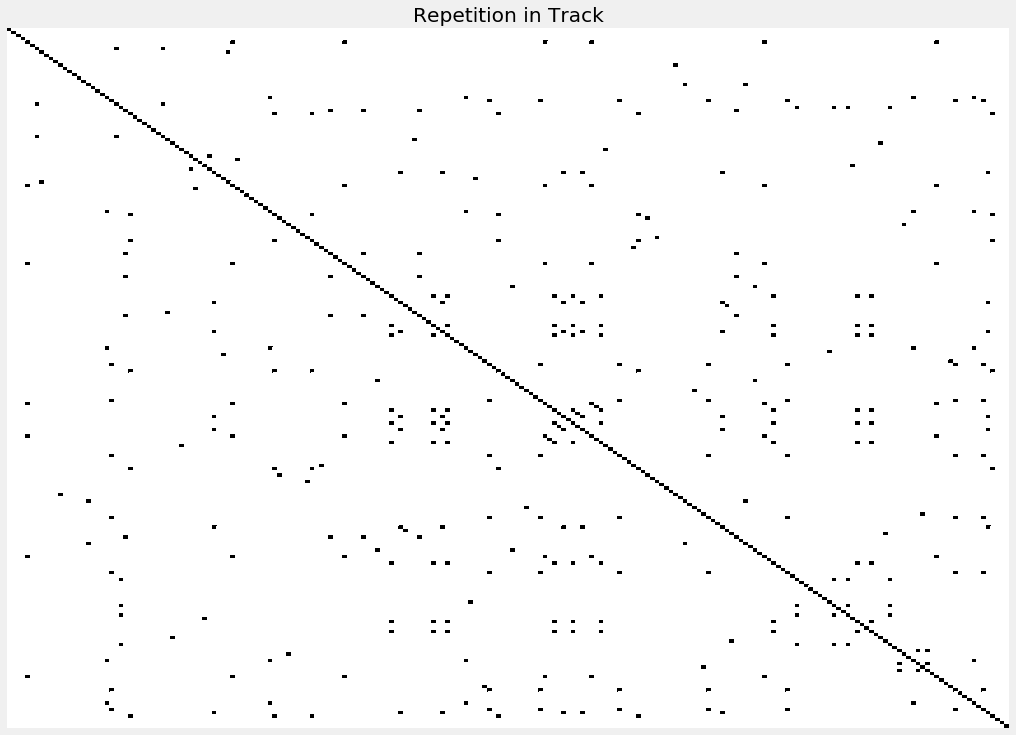



The repetition ratio for this track is 0.34



 better than ya 
 understand i cant tell 
 no more kissed cold its an went true 
 didnt want to feel safe fall 
 and you tell me im the fool 
 start em locked them now tell 
 baby dont stop hard 
 yeah we wont go when we for playing yo no i wont divine 
 those hands 
 then alone 
 hey and the special look so long 
 wandering on as the pain 
 all night im fed up 
 i am top phone im in 
 with my car 
 had a drop for your hand baby 
 im just not a care for a while be ready 
 and let yo mountain 
 cause you are the best of my love 
 will never forget about you 
 i got a bag for monique a bag for fonna 
 i got a hard head but you were dumb 
 all the big special time as did 
 two thoughts its burned to sleep 
 never feeling like you oh 
 waiting for your call 
 im prepared to sacrifice my life 
 i deserve a try have you show me actually what 
 this is words or let me cry 
 give me 
 when a man loves a woman 
 dont call me why youre so sorry an

In [42]:
lyrics = generate_lyrics('eyes are for lovers',
                         seq_len=4,
                         song_len=250,
                         model_dir=None,
                         temperature=1.6
                        )
lyric_grid(lyrics)

While there's no repetition, this feels like an over correctin and the word selection can at times feel disjointed.

# CONTINUE TO NOTEBOOK 04b: MODELING